<a href="https://colab.research.google.com/github/Ed-Cheng/ML_based-trading-strategy/blob/main/ML_trading_clean01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install yfinance


In [1]:
# Install talib
# https://stackoverflow.com/questions/49648391/how-to-install-ta-lib-in-google-colab?newreg=5d6b616eb23c4a2f9f6e78a8c948d56d
url = "https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h166bdaf_1.tar.bz2"
!curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1
url = "https://anaconda.org/conda-forge/ta-lib/0.4.19/download/linux-64/ta-lib-0.4.19-py39hd257fcd_4.tar.bz2"
!curl -L $url | tar xj -C /usr/local/lib/python3.9/dist-packages/ lib/python3.9/site-packages/talib --strip-components=3


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4379    0  4379    0     0  48120      0 --:--:-- --:--:-- --:--:-- 48120
100  517k  100  517k    0     0  1668k      0 --:--:-- --:--:-- --:--:-- 1668k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4387    0  4387    0     0  51611      0 --:--:-- --:--:-- --:--:-- 51611
100  389k  100  389k    0     0  1928k      0 --:--:-- --:--:-- --:--:-- 1928k


In [96]:
import copy
import talib

import yfinance as yf
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8,6)

from pandas_datareader import data
from datetime import datetime
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix


In [3]:
def store_stock_data(target_stock, start_date, end_date):
  """ read the stock data from yahoo and store it to csv """
  # convert to pandasreader format
  yf.pdr_override()

  # read and save pandas df
  df = data.get_data_yahoo([target_stock], start_date, end_date)
  df.to_csv(f"./{target_stock}.csv")

def load_stock_data(target_stock):
  """ Read the stock csv files and only keep the info we need """
  # read csv file  
  df = pd.read_csv(f"{target_stock}.csv", index_col=0)
  # fill in missing values, if any
  df = df.interpolate()
  df.index = pd.to_datetime(df.index)

  return df


In [13]:
# start_date = datetime(2015, 1, 1)
# end_date = datetime(2023, 1, 1) 

start_date = datetime(1990, 1, 1)
end_date = datetime(2022, 9, 12) 

store_stock_data("TSLA", start_date, end_date)

[*********************100%***********************]  1 of 1 completed


In [36]:
def add_change(stock_df):
  stock_df["tmr_close"] = stock_df.shift(-1)["Close"]
  stock_df["change"] = (stock_df["tmr_close"] > stock_df["Close"]).astype(int)

def add_indicator(stock_df):
  """ 
    All indicators are relative values
    Indicators used:
    - Guppy Multiple Moving Average (ema=3,5,8,10,12,15,30,35,40,45,50,60)
    - RSI (period=14)
    - Rate of volume change Percentage (period=5,10)
    - Stochastic Oscillator (period=14)
  """
  gmma_days = [3, 5, 8, 10, 12, 15, 30, 35, 40, 45, 50, 60]
  for days in gmma_days:
    stock_df[f"ema{days}"] = talib.EMA(stock_df["Close"], timeperiod=days) / stock_df["Close"]

  # RSI
  stock_df["rsi"] = talib.RSI(stock_df["Close"], timeperiod=14)

  general_days = [1, 5, 10, 20]
  for days in general_days:
    # Relative volume of today (rel_vol): (today volume) / (past x days' avg volume)
    # Unit in multiples, 1.5 means 150%
    stock_df[f"rel_vol{days}"] = stock_df["Volume"]/talib.MA(stock_df["Volume"], timeperiod=days)

    # Past x day's price chg in % (price_chg): (today price - past x day's price) / (past x day's price)
    # Unit in %
    stock_df[f"price_chg{days}"] = (stock_df["Close"] - stock_df.shift(days)["Close"])/stock_df.shift(days)["Close"]

    # Past x day's avg volume * price_chg (vol*price): (past x days' avg volume) * (price_chg)
    # Unit in volume*%
    stock_df[f"vol*price{days}"] = talib.MA(stock_df["Volume"], timeperiod=days)*stock_df[f"price_chg{days}"]

    # Relative (vol*price) of today (rel_vol*price): (today vol*price) / (past x days' vol*price)
    # Unit in multiples, 1.5 means 150%
    stock_df[f"rel_vol*price{days}"] = stock_df["vol*price1"]/stock_df[f"vol*price{days}"]


  stock_df["stoch_k"], stock_df["stoch_d"] = talib.STOCH(stock_df["High"], 
                                                         stock_df["Low"], 
                                                         stock_df["Close"], 
                                                         fastk_period=14)

def add_indicator_yt(stock_df):
  horizons = [2,5,30,60]
  # new_predictors = []

  for horizon in horizons:
      rolling_averages = stock_df.rolling(horizon).mean()
      
      ratio_column = f"Close_Ratio_{horizon}"
      stock_df[ratio_column] = stock_df["Close"] / rolling_averages["Close"]
      
      trend_column = f"Trend_{horizon}"
      stock_df[trend_column] = stock_df.shift(1).rolling(horizon).sum()["change"]
      
      # new_predictors += [ratio_column, trend_column]




In [37]:
TSLA = load_stock_data("TSLA")
add_change(TSLA)
add_indicator(TSLA)
add_indicator_yt(TSLA)


In [38]:
TSLA.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'tmr_close',
       'change', 'ema3', 'ema5', 'ema8', 'ema10', 'ema12', 'ema15', 'ema30',
       'ema35', 'ema40', 'ema45', 'ema50', 'ema60', 'rsi', 'rel_vol1',
       'price_chg1', 'vol*price1', 'rel_vol*price1', 'rel_vol5', 'price_chg5',
       'vol*price5', 'rel_vol*price5', 'rel_vol10', 'price_chg10',
       'vol*price10', 'rel_vol*price10', 'rel_vol20', 'price_chg20',
       'vol*price20', 'rel_vol*price20', 'stoch_k', 'stoch_d', 'Close_Ratio_2',
       'Trend_2', 'Close_Ratio_5', 'Trend_5', 'Close_Ratio_30', 'Trend_30',
       'Close_Ratio_60', 'Trend_60'],
      dtype='object')

In [58]:
del TSLA["rel_vol*price1"]
del TSLA["rel_vol1"]

In [89]:
print(f"Before removal {len(TSLA)}")
TSLA = TSLA.replace([np.inf, -np.inf], np.nan).dropna(axis=0)
print(f"After removal {len(TSLA)}")


Before removal 3072
After removal 3004


In [90]:
for ind in TSLA.columns:
  print(ind, end=" ")
  print(f"Min-Max: {np.min(TSLA[ind])} {np.max(TSLA[ind])}")

Open Min-Max: 1.3259999752044678 411.4700012207031
High Min-Max: 1.3426669836044312 414.4966735839844
Low Min-Max: 1.2999999523162842 405.6666564941406
Close Min-Max: 1.3040000200271606 409.9700012207031
Adj Close Min-Max: 1.3040000200271606 409.9700012207031
Volume Min-Max: 1777500 914082000
tmr_close Min-Max: 1.3366669416427612 409.9700012207031
change Min-Max: 0 1
ema3 Min-Max: 0.8969778205250193 1.150566232651923
ema5 Min-Max: 0.8325443111341367 1.2728139238237042
ema8 Min-Max: 0.7734641754219146 1.4151339490739534
ema10 Min-Max: 0.7462718002154628 1.4894290682181648
ema12 Min-Max: 0.7243731230943917 1.5506786276319946
ema15 Min-Max: 0.6977995878429726 1.6221976084093557
ema30 Min-Max: 0.61657379056408 1.7556310116211284
ema35 Min-Max: 0.5976878610106268 1.7563271185480622
ema40 Min-Max: 0.5800251565537322 1.7471168831948647
ema45 Min-Max: 0.5642889167806944 1.7316011268839557
ema50 Min-Max: 0.550126587916216 1.7121428830780165
ema60 Min-Max: 0.5255710189827357 1.6671653860065414
r

In [61]:
"""
  ['ema3', 'ema5', 'ema8', 'ema10', 'ema12', 'ema15', 'ema30',
  'ema35', 'ema40', 'ema45', 'ema50', 'ema60', 'rsi',
  'price_chg1', 'vol*price1', 'rel_vol5', 'price_chg5',
  'vol*price5', 'rel_vol*price5', 'rel_vol10', 'price_chg10',
  'vol*price10', 'rel_vol*price10', 'rel_vol20', 'price_chg20',
  'vol*price20', 'rel_vol*price20', 'stoch_k', 'stoch_d', 'Close_Ratio_2',
  'Trend_2', 'Close_Ratio_5', 'Trend_5', 'Close_Ratio_30', 'Trend_30',
  'Close_Ratio_60', 'Trend_60']
"""

indicators = ['ema3', 'ema5', 'ema8', 'ema10', 'ema12', 'ema15', 'ema30',
  'ema35', 'ema40', 'ema45', 'ema50', 'ema60', 'rsi',
  'price_chg1', 'vol*price1', 'rel_vol5', 'price_chg5',
  'vol*price5', 'rel_vol*price5', 'rel_vol10', 'price_chg10',
  'vol*price10', 'rel_vol*price10', 'rel_vol20', 'price_chg20',
  'vol*price20', 'rel_vol*price20', 'stoch_k', 'stoch_d', 'Close_Ratio_2',
  'Trend_2', 'Close_Ratio_5', 'Trend_5', 'Close_Ratio_30', 'Trend_30',
  'Close_Ratio_60', 'Trend_60']

# backtest setting

In [174]:
def backtest(data, model, indicators, start=2000, step=500):
    all_predictions = []
    all_importance = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions, feature_importance = predict(train, test, indicators, model)
        all_predictions.append(predictions)
        all_importance.append(feature_importance)
    
    return pd.concat(all_predictions), all_importance

def predict(train, test, indicators, model):
    model.fit(train[indicators], train["change"])
    # preds = model.predict(test[indicators])[:,1]
    preds0 = model.predict_proba(test[indicators])[:,0]
    preds1 = model.predict_proba(test[indicators])[:,1]
    # preds[preds >=.6] = 1
    # preds[preds <.6] = 0
    preds0 = pd.Series(preds0, index=test.index, name="preds0")
    preds1 = pd.Series(preds1, index=test.index, name="preds1")
    pdlist = [preds0, preds1, test["change"]]
    combined = pd.concat(pdlist, axis=1)

    feature_importance = pd.DataFrame(data=model.feature_importances_,
                                      index=model.feature_names_in_,
                                      columns=["importance"])

    return combined, feature_importance

## backtest 1, random forest all parameters

In [114]:
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

predictions = backtest(TSLA, model, indicators)


In [115]:
confusion_matrix(predictions["change"], predictions["Predictions"])

array([[401,  63],
       [471,  69]])

In [116]:
precision_score(predictions["change"], predictions["Predictions"])


0.5227272727272727

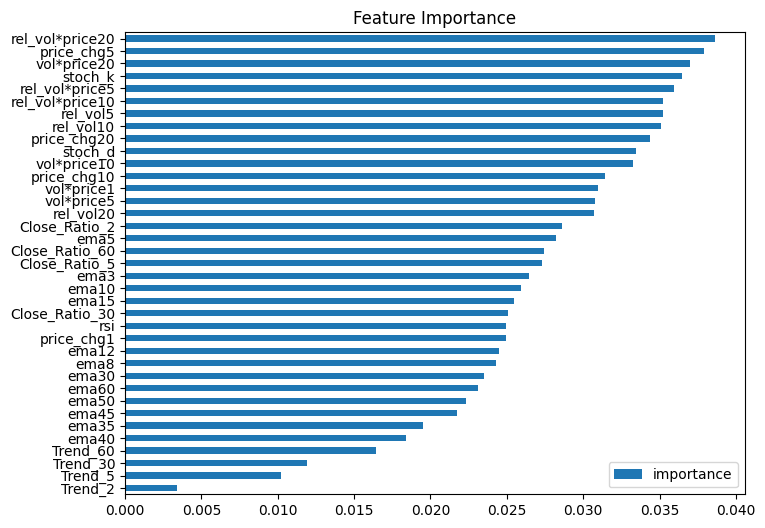

In [118]:
fi = pd.DataFrame(data=model.feature_importances_,
                  index=model.feature_names_in_,
                  columns=["importance"])
fi.sort_values("importance").plot(kind="barh", title="Feature Importance")
plt.show()

## backtest 2, xgboost all parameters

In [121]:
model = xgb.XGBClassifier(n_estimators=200, random_state=10)

predictions = backtest(TSLA, model, indicators)


In [122]:
confusion_matrix(predictions["change"], predictions["Predictions"])

array([[268, 196],
       [303, 237]])

In [123]:
precision_score(predictions["change"], predictions["Predictions"])


0.5473441108545035

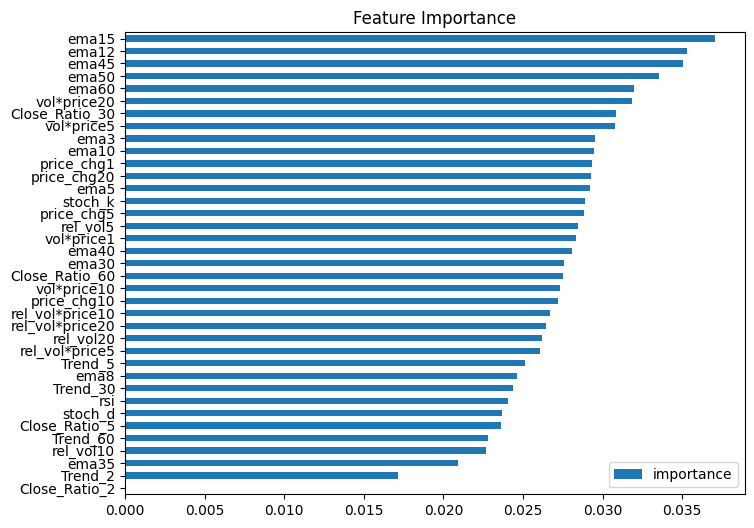

In [124]:
fi = pd.DataFrame(data=model.feature_importances_,
             index=model.feature_names_in_,
             columns=["importance"])
fi.sort_values("importance").plot(kind="barh", title="Feature Importance")
plt.show()

## backtest 3, xgboost all parameters

In [146]:
model = xgb.XGBClassifier(n_estimators=200, random_state=10)

predictions = backtest(TSLA, model, indicators)


In [147]:
for i in np.arange(0.4, 0.9, 0.05):
  predictions['final_pred'] = np.where(predictions['preds1'] > i, 1, 0)
  print(i, end=": ")
  score = precision_score(predictions["change"], predictions["final_pred"])
  print(score)

0.4: 0.5376884422110553
0.45: 0.5335753176043557
0.5: 0.5279383429672447
0.55: 0.5441176470588235
0.6: 0.5473441108545035
0.6499999999999999: 0.5305039787798409
0.7: 0.5386996904024768
0.75: 0.5404411764705882
0.7999999999999999: 0.5227272727272727
0.8499999999999999: 0.4876543209876543


In [155]:
predictions['final_pred'] = np.where(predictions['preds1'] > 0.6, 1, 0)


0.5423728813559322


In [158]:
analyze = predictions.iloc[len(predictions) - 20:].copy()

score = precision_score(analyze["change"], analyze["final_pred"])
print(score)

0.5


In [144]:
for i in np.arange(0.4, 0.9, 0.05):
  predictions['final_pred'] = np.where(predictions['preds1'] > i, 1, 0)
  print(i, end=": ")
  score = precision_score(predictions["change"], predictions["final_pred"])
  print(score)


0.4: 0.5268456375838926
0.45: 0.5351851851851852
0.5: 0.5408163265306123
0.55: 0.5331858407079646
0.6: 0.5301204819277109
0.6499999999999999: 0.518918918918919
0.7: 0.5137614678899083
0.75: 0.5441696113074205
0.7999999999999999: 0.5427350427350427
0.8499999999999999: 0.5245901639344263


In [137]:
predictions['final_pred'] = np.where(predictions['preds1'] > 0.5, 1, 0)

In [ ]:
confusion_matrix(predictions["change"], predictions["Predictions"])

array([[268, 196],
       [303, 237]])

In [ ]:
precision_score(predictions["change"], predictions["Predictions"])


0.5473441108545035

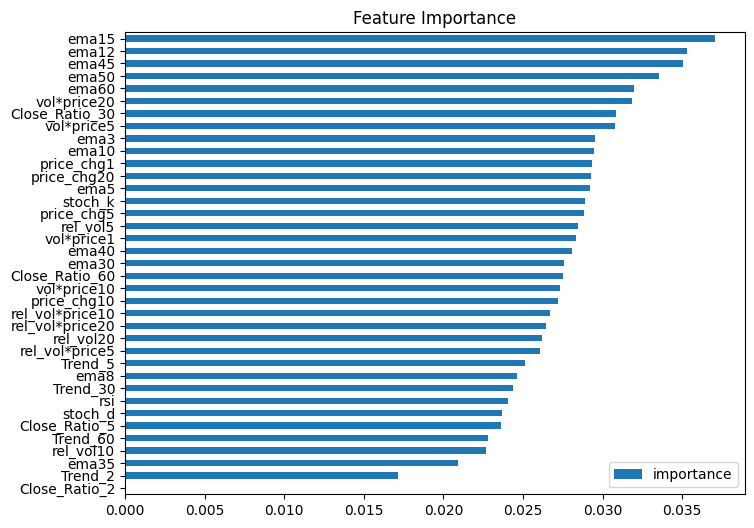

In [ ]:
fi = pd.DataFrame(data=model.feature_importances_,
             index=model.feature_names_in_,
             columns=["importance"])
fi.sort_values("importance").plot(kind="barh", title="Feature Importance")
plt.show()

## backtest 4, xgboost volume only

In [159]:
model = xgb.XGBClassifier(n_estimators=200, random_state=10)

indicators = ['price_chg1', 'vol*price1', 'rel_vol5', 'price_chg5',
  'vol*price5', 'rel_vol*price5', 'rel_vol10', 'price_chg10',
  'vol*price10', 'rel_vol*price10', 'rel_vol20', 'price_chg20',
  'vol*price20', 'rel_vol*price20']

predictions = backtest(TSLA, model, indicators)


In [160]:
for i in np.arange(0.4, 0.9, 0.05):
  predictions['final_pred'] = np.where(predictions['preds1'] > i, 1, 0)
  print(i, end=": ")
  score = precision_score(predictions["change"], predictions["final_pred"])
  print(score)

0.4: 0.5398089171974523
0.45: 0.5327586206896552
0.5: 0.5371428571428571
0.55: 0.5357142857142857
0.6: 0.5245901639344263
0.6499999999999999: 0.5188172043010753
0.7: 0.5216049382716049
0.75: 0.5478927203065134
0.7999999999999999: 0.5463414634146342
0.8499999999999999: 0.5089820359281437


In [165]:
# manually pick the threshold
predictions['final_pred'] = np.where(predictions['preds1'] > 0.75, 1, 0)

print(precision_score(predictions["change"], predictions["final_pred"]))
print(confusion_matrix(predictions["change"], predictions["final_pred"]))


0.5478927203065134
[[346 118]
 [397 143]]


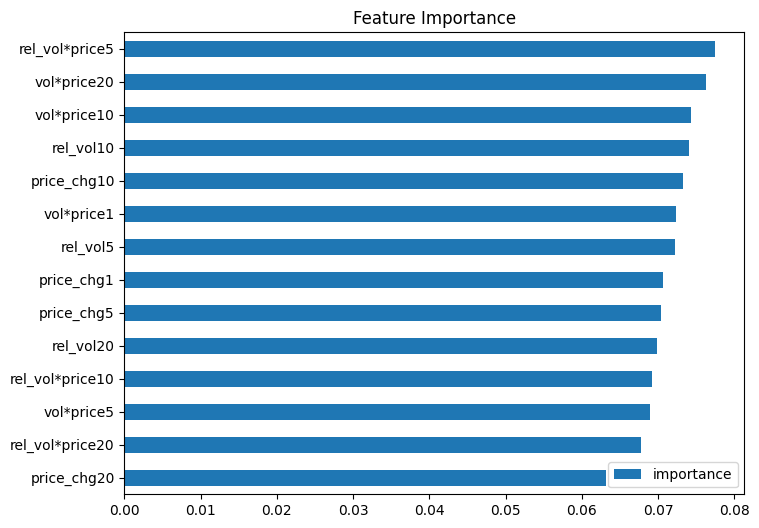

In [166]:
fi = pd.DataFrame(data=model.feature_importances_,
             index=model.feature_names_in_,
             columns=["importance"])
fi.sort_values("importance").plot(kind="barh", title="Feature Importance")
plt.show()

## backtest 5, xgboost ema only

In [175]:
model = xgb.XGBClassifier(n_estimators=200, random_state=10)

indicators = ['ema3', 'ema5', 'ema8', 'ema10', 'ema12', 'ema15', 'ema30',
  'ema35', 'ema40', 'ema45', 'ema50', 'ema60', 
  'price_chg1', 'price_chg5',
   'price_chg10','price_chg20']

predictions, all_importance = backtest(TSLA, model, indicators)


In [176]:
for i in np.arange(0.4, 0.9, 0.05):
  predictions['final_pred'] = np.where(predictions['preds1'] > i, 1, 0)
  print(i, end=": ")
  score = precision_score(predictions["change"], predictions["final_pred"])
  print(score)

0.4: 0.5316045380875203
0.45: 0.5400696864111498
0.5: 0.5447470817120622
0.55: 0.5392781316348195
0.6: 0.5334872979214781
0.6499999999999999: 0.5456852791878173
0.7: 0.5488505747126436
0.75: 0.535593220338983
0.7999999999999999: 0.52
0.8499999999999999: 0.5252525252525253


In [177]:
# manually pick the threshold
predictions['final_pred'] = np.where(predictions['preds1'] > 0.75, 1, 0)

print(precision_score(predictions["change"], predictions["final_pred"]))
print(confusion_matrix(predictions["change"], predictions["final_pred"]))

0.535593220338983
[[327 137]
 [382 158]]


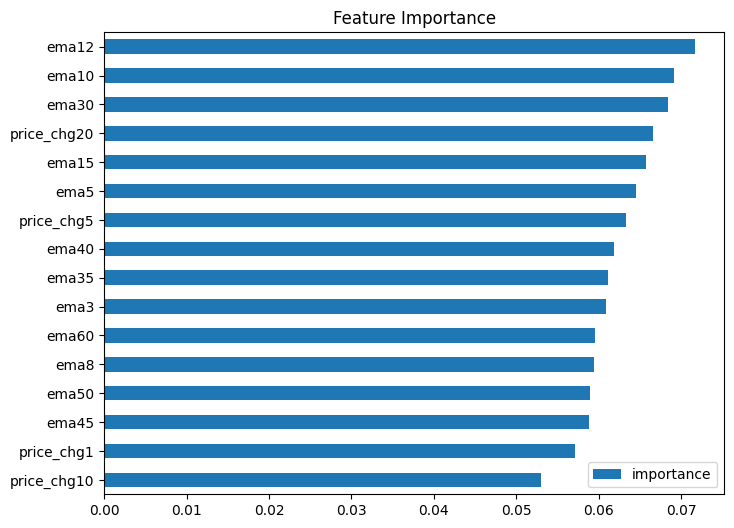

In [178]:
fi = all_importance[0]
fi.sort_values("importance").plot(kind="barh", title="Feature Importance")
plt.show()

## backtest 6, xgboost ema only, multiple models

In [181]:
model = xgb.XGBClassifier(n_estimators=200, random_state=10)

indicators = ['ema3', 'ema5', 'ema8', 'ema10', 'ema12', 'ema15', 'ema30',
  'ema35', 'ema40', 'ema45', 'ema50', 'ema60', 
  'price_chg1', 'price_chg5',
   'price_chg10','price_chg20']

predictions01, all_importance01 = backtest(TSLA, model, indicators, step=128)
predictions02, all_importance02 = backtest(TSLA, model, indicators, step=64)
predictions03, all_importance03 = backtest(TSLA, model, indicators, step=32)


In [196]:
predictions01['final_pred'] = np.where(predictions01['preds1'] > 0.6, 1, 0)
predictions02['final_pred'] = np.where(predictions02['preds1'] > 0.6, 1, 0)
predictions03['final_pred'] = np.where(predictions03['preds1'] > 0.6, 1, 0)

In [197]:
print(precision_score(predictions["change"], predictions01['final_pred']))
print(precision_score(predictions["change"], predictions02['final_pred']))
print(precision_score(predictions["change"], predictions03['final_pred']))

0.5306122448979592
0.5227272727272727
0.5431818181818182


In [198]:
print(confusion_matrix(predictions01["final_pred"], predictions02["final_pred"]))
print(confusion_matrix(predictions01["final_pred"], predictions03["final_pred"]))
print(confusion_matrix(predictions02["final_pred"], predictions03["final_pred"]))

[[516  47]
 [ 48 393]]
[[482  81]
 [ 82 359]]
[[512  52]
 [ 52 388]]


In [199]:
combined = pd.DataFrame()
combined["combine"] = predictions01["final_pred"] + predictions02["final_pred"] + predictions03["final_pred"]

In [202]:
combined['answer'] = np.where(combined['combine'] > 0.5, 1, 0)

print(precision_score(predictions["change"], combined['answer']))
print(confusion_matrix(predictions["change"], combined['answer']))

0.539622641509434
[[220 244]
 [254 286]]


In [ ]:
for i in np.arange(0.4, 0.9, 0.05):
  predictions['final_pred'] = np.where(predictions['preds1'] > i, 1, 0)
  print(i, end=": ")
  score = precision_score(predictions["change"], predictions["final_pred"])
  print(score)

0.4: 0.5316045380875203
0.45: 0.5400696864111498
0.5: 0.5447470817120622
0.55: 0.5392781316348195
0.6: 0.5334872979214781
0.6499999999999999: 0.5456852791878173
0.7: 0.5488505747126436
0.75: 0.535593220338983
0.7999999999999999: 0.52
0.8499999999999999: 0.5252525252525253


In [ ]:
# manually pick the threshold
predictions['final_pred'] = np.where(predictions['preds1'] > 0.75, 1, 0)

print(precision_score(predictions["change"], predictions["final_pred"]))
print(confusion_matrix(predictions["change"], predictions["final_pred"]))

0.535593220338983
[[327 137]
 [382 158]]


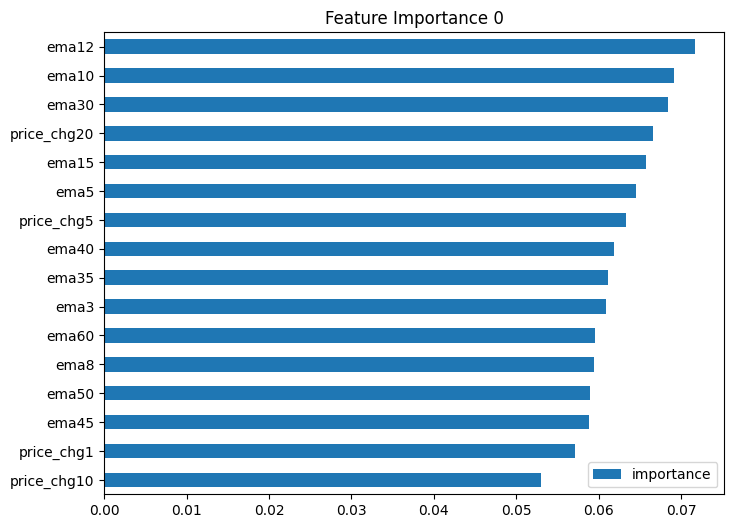

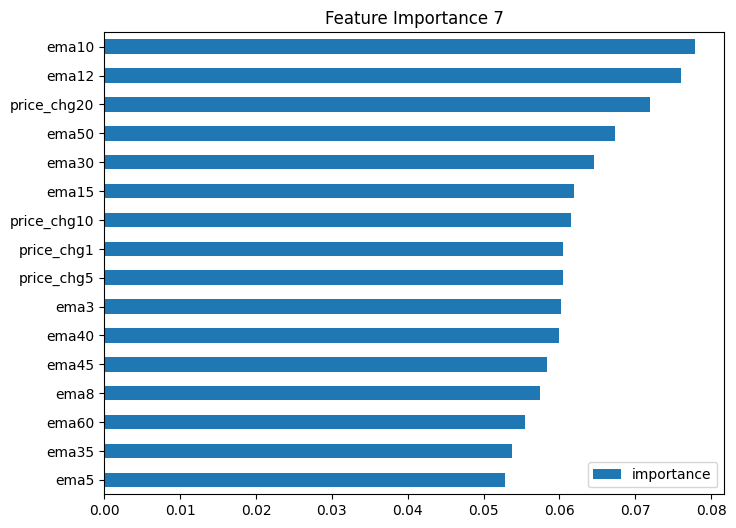

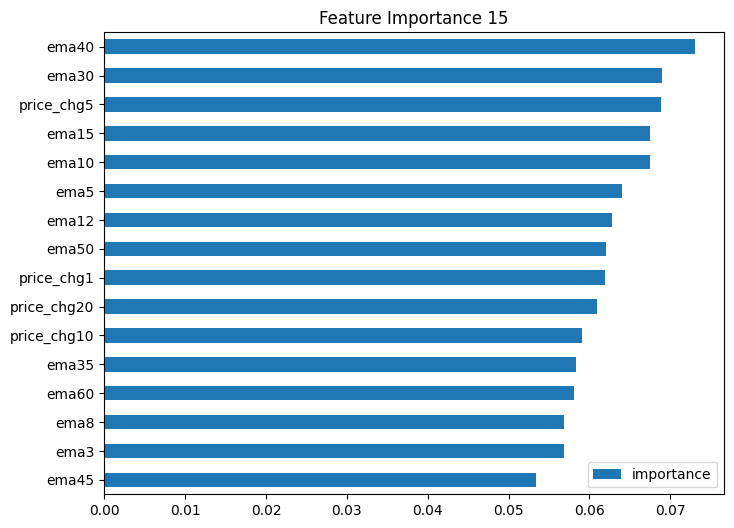

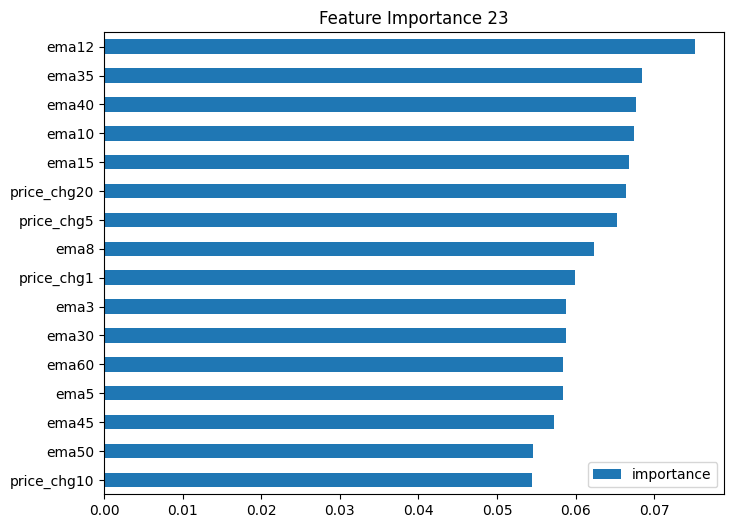

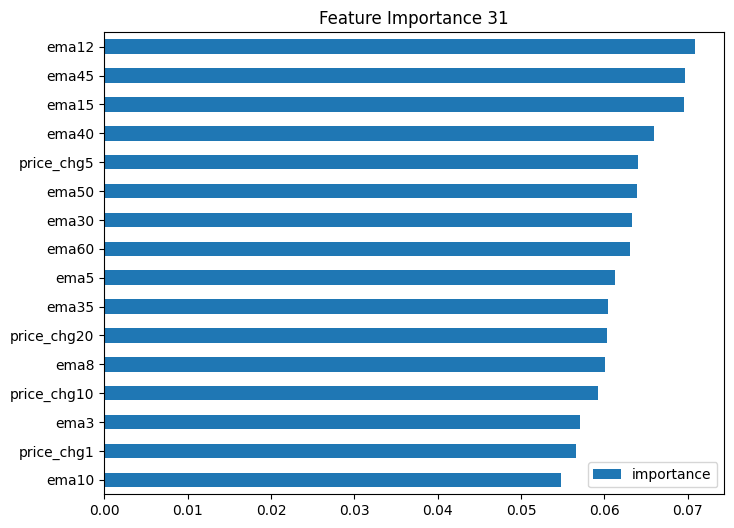

In [207]:
for i in np.linspace(0, len(all_importance03)-1, 5):
  i = int(i)
  all_importance03[i].sort_values("importance").plot(kind="barh", title=f"Feature Importance {i}")
  plt.show()
